<a href="https://colab.research.google.com/github/KimJisanER/RDKit-Bioinf/blob/main/RDKit_pandas_support_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**RDKit pandas support**

This is a quick tutorial will show some of the ways you can use RDKit together with pandas.

In [1]:
from __future__ import print_function
%matplotlib inline

In [3]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 37.2 MB/s eta 0:00:00


In [4]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

# The next line is commented out 
# because GitHub does not render svg's embedded in notebooks
IPythonConsole.ipython_useSVG=False

In [5]:
df = pd.read_csv('chembl_drugs.txt.gz', sep='\t')

In [6]:
[str(x) for x in df.columns]

['PARENT_MOLREGNO',
 'CHEMBL_ID',
 'SYNONYMS',
 'DEVELOPMENT_PHASE',
 'RESEARCH_CODES',
 'APPLICANTS',
 'USAN_STEM',
 'USAN_STEM_DEFINITION',
 'USAN_STEM_SUBSTEM',
 'USAN_YEAR',
 'FIRST_APPROVAL',
 'ATC_CODE',
 'ATC_CODE_DESCRIPTION',
 'INDICATION_CLASS',
 'SC_PATENT_NO',
 'DRUG_TYPE',
 'RULE_OF_FIVE',
 'FIRST_IN_CLASS',
 'CHIRALITY',
 'PRODRUG',
 'ORAL',
 'PARENTERAL',
 'TOPICAL',
 'BLACK_BOX',
 'AVAILABILITY_TYPE',
 'WITHDRAWN_YEAR',
 'WITHDRAWN_COUNTRY',
 'WITHDRAWN_REASON',
 'CANONICAL_SMILES']

In [7]:
len(df)

11442

In [8]:
df = df[df['CANONICAL_SMILES'].notnull() & # Keep cpds with SMILES
        (df['RULE_OF_FIVE'] == 'Y') & # that respect Ro5
        (df['DEVELOPMENT_PHASE'] == 4)] # are on the market

In [9]:
len(df)

1284

Table contains CANONICAL_SMILES with SMILES which we can convert to RDKit molecules (default name ROMol)

In [10]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='CANONICAL_SMILES')

In [11]:
df = df[~df['ROMol'].isnull()]

In [13]:
df['SYNONYMS']

0                      Fluorometholone Acetate (FDA, USAN)
1                 Levodopa (BAN, FDA, INN, JAN, USAN, USP)
3                          Alvimopan (BAN, FDA, INN, USAN)
4              Norfloxacin (BAN, FDA, INN, JAN, USAN, USP)
5                      Oxcarbazepine (BAN, FDA, INN, USAN)
                               ...                        
11426    Tramadol (BAN, INN); Tramadol HCl (FDA, JAN, U...
11429                             Fluoroethylcholine (18f)
11432                  Dimethylaminopropionylphenothiazine
11433                                         Fabomotizole
11436                 Probenecid (BAN, FDA, INN, JAN, USP)
Name: SYNONYMS, Length: 1284, dtype: object

In [14]:
df['name'] = df.apply(lambda x: x['SYNONYMS'].split('(')[0] if type(x['SYNONYMS']) is str else None, axis=1)

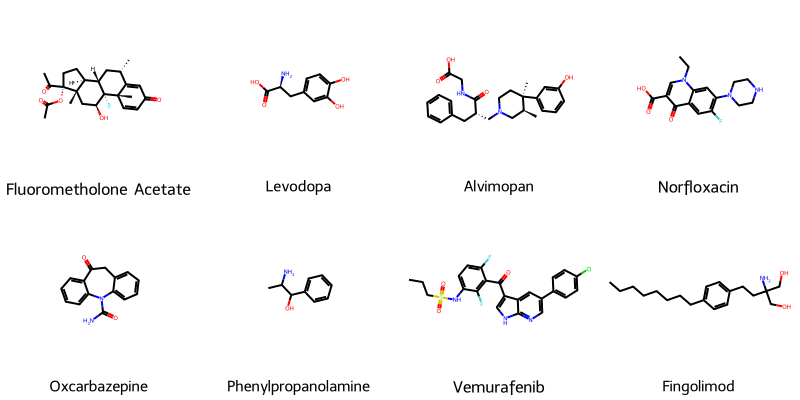

In [15]:
PandasTools.FrameToGridImage(df.head(8), legendsCol='name', molsPerRow=4)

Calculate some descriptors and visualize distributions

In [16]:
from rdkit.Chem import Descriptors

In [17]:
df['MW'] = df['ROMol'].map(Descriptors.MolWt)
df['logP'] = df['ROMol'].map(Descriptors.MolLogP)

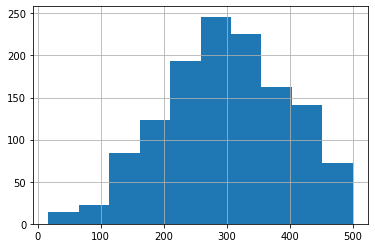

In [18]:
#doctest: IGNORE
df['MW'].hist();

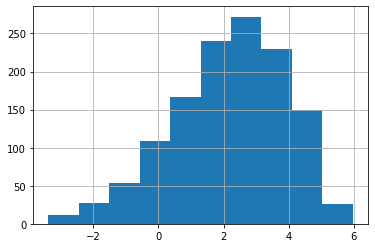

In [19]:
#doctest: IGNORE
df['logP'].hist();

Do a substructure search on a dataframe

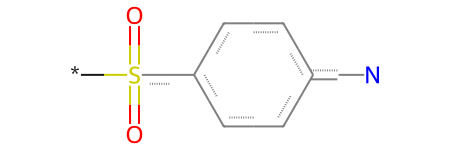

In [20]:
query = Chem.MolFromSmarts('Nc1ccc(S(=O)(=O)-[*])cc1')
query

Notice that unspecified bonds in the SMARTS are "single or aromatic" queries. We could make this query a bit more specific:

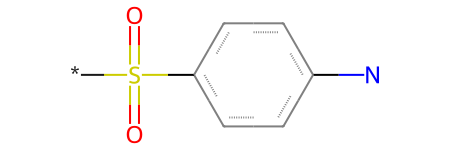

In [21]:
query = Chem.MolFromSmarts('N-c1ccc(-S(=O)(=O)-[*])cc1')
query

We do a substruture search by using the operator >= on a molecule column.

Here's an example where we do the search and count the number of matching rows:

In [35]:
len(df[df['ROMol'] >= query])

35

RDKit by defaults highlights the matched substructures

In [50]:
df[df['ROMol'] >= query][['SYNONYMS', 'ROMol']].head()

,SYNONYMS,ROMol
45,"Sulfadimethoxine (BAN, INN, JAN, MI, NF, USP);...",<rdkit.Chem.rdchem.Mol object at 0x7fe4a653f350>
48,Bendrofluazide (BAN); Bendroflumethiazide (FDA...,<rdkit.Chem.rdchem.Mol object at 0x7fe4a653f2e0>
51,"Hydrochlorothiazide (BAN, FDA, INN, JAN, USP)",<rdkit.Chem.rdchem.Mol object at 0x7fe4a653f190>
155,"Sulfapyridine (BAN, FDA, INN, USP); Sulfapyrid...",<rdkit.Chem.rdchem.Mol object at 0x7fe4a65387b0>
266,"Sulfaphenazole (BAN, FDA, INN, JAN, MI)",<rdkit.Chem.rdchem.Mol object at 0x7fe4a6533740>


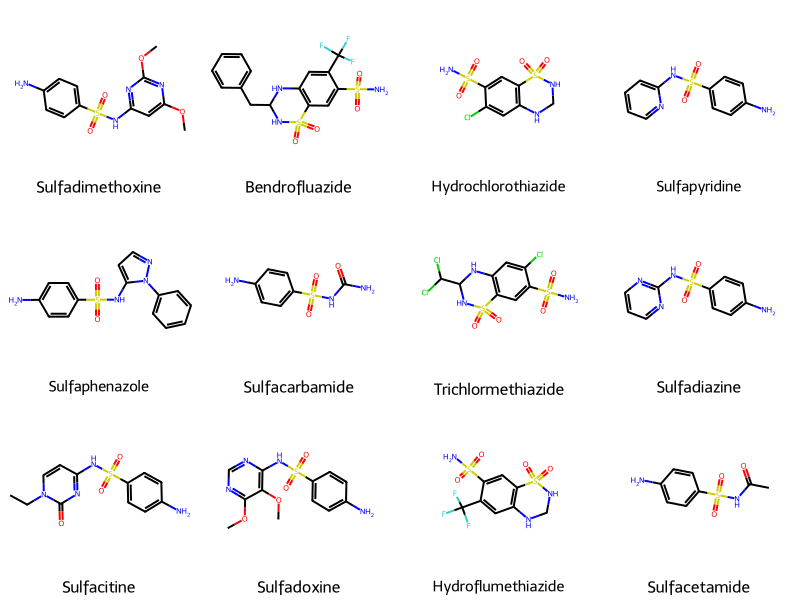

In [51]:
PandasTools.FrameToGridImage(df[df['ROMol'] >= query].head(12), legendsCol='name', molsPerRow=4)

In [52]:
PandasTools.WriteSDF(df, 'approved_drugs.sdf', idName='CHEMBL_ID', properties=df.columns)

Tutorial author: Samo Turk, Jan. 2017